# Feature Extraction using Convolutional Neural Networks
[GitHub Tutorial:CIFAR 10 feature extraction using pretrained convolutional depp neural networks from keras library](https://github.com/rnoxy/cifar10-cnn/blob/master/Feature_extraction_using_keras.ipynb)

In [ ]:
#Github code
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Please choose the CNN network [0-3]: 3
Selected network:  vgg19


In [ ]:
 pip install myutils

  Created wheel for myutils: filename=myutils-0.0.21-py3-none-any.whl size=1364 sha256=11b9de2a0793f07c79ee4a4ed530e35c98d41561f93f20883f1709c79d09dee4
  Stored in directory: /root/.cache/pip/wheels/8e/89/9f/ab7f23dcc9ba30d64a298bcfc29c4e7e9ec59110ddc69aac12
Successfully built myutils


In [ ]:
#github
import time
import myutils
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D, Conv2D
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


## Load CIFAR10 data

170508288/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


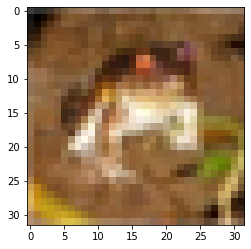

In [ ]:
#github
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

## Create model

In [ ]:
#github
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    return ResNet50(input_tensor=tf_input, include_top=False)

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    convolutional_layer = Conv2D(50,1)(model.output)
    output_pooled = AveragePooling2D((7, 7))(convolutional_layer)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

## Data generator for tensorflow

[Tensorflow 1 to 2](https://stackoverflow.com/questions/60966376/best-practice-to-write-code-compatible-to-both-tensorflow-1-and-2)

In [ ]:
#github
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize(batch_of_images_placeholder, (input_shape[:2]), method='bilinear')

In [ ]:
#github
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

## Feature extraction

In [ ]:
with tf.Session() as sess:
    # setting tensorflow session to Keras
    K.set_session(sess)
    # setting phase to training
    K.set_learning_phase(1)  # 0 - test,  1 - train

    model = create_model()

    data_train_gen = data_generator(sess, X_train, y_train)
    ftrs_training = model.predict_generator(data_train_gen(), n_training/batch_size, verbose=1)

    data_test_gen = data_generator(sess, X_test, y_test)
    ftrs_testing = model.predict_generator(data_test_gen(), n_testing/batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


80150528/80134624 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


In [ ]:
#github
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

#np.savez_compressed("features/CIFAR10_{}-keras_features.npz".format(selected_network),features_training=features_training,features_testing=features_testing,labels_training=y_train,labels_testing=y_test)

## Feature visualization

### Feature analysis (using PCA)

In [ ]:
#github
import numpy as np
import myutils

#data = np.load("features/CIFAR10_{}-keras_features.npz".format(selected_network))

X_training = features_training
y_training = y_train

X_testing = features_testing
y_testing = y_test

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 50)


# File export

In [ ]:
import pandas as pd
y_training_1=np.reshape(y_training,(50000,1))
y_testing_1=np.reshape(y_testing,(10000,1))
data_train= np.concatenate((X_training,y_training_1),axis=1)
data_test= np.concatenate((X_testing,y_testing_1),axis=1)
df_train=pd.DataFrame(data=data_train)
df_test=pd.DataFrame(data=data_test)

In [ ]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,-4.419523,-2.266680,0.799574,-1.081009,-0.941605,1.210477,-0.145699,-1.074489,-0.235584,3.783177,1.982686,-6.875845,1.101928,-5.249974,-1.425183,6.581364,-3.084167,3.196840,3.008657,8.025002,1.189654,-0.811864,-0.672177,1.957772,0.724044,0.476730,-2.303738,1.451834,0.761049,-0.725975,-2.412403,-1.112644,0.383099,-2.989756,7.131237,0.099750,3.927369,-2.848276,0.368142,2.365374,2.942115,-2.255992,-6.767223,0.198545,-1.565484,1.359341,4.064276,-3.116261,0.185193,2.463589,6.0
1,-0.904093,0.440515,4.357658,1.144337,-4.625338,1.116826,-5.932447,-3.721859,8.302789,7.282394,11.042481,-1.592129,-0.305553,-2.471076,-3.970523,-2.152364,4.293311,-0.362736,2.860235,9.297611,1.802193,-2.836930,1.435787,2.639816,-4.049674,-1.576508,-5.725641,5.061689,-4.518792,-3.335987,0.353541,-2.950994,0.452413,1.254786,-2.755203,-0.280901,-2.567887,-0.436348,-0.529697,-0.436315,2.024866,-3.370251,-4.956428,2.070215,-1.589481,3.962628,4.967786,-0.868280,1.618916,-2.556973,9.0
2,2.080133,-0.555811,2.155060,0.676354,-6.906185,3.672575,-3.261605,-5.664647,3.204818,3.221462,4.839210,-4.579479,-0.283714,-0.130491,-1.090225,0.000545,-1.049760,-0.439541,6.161247,3.460378,1.426616,-1.265782,1.502595,-2.399828,-3.374687,2.967140,-5.496383,1.845897,-4.422836,-0.294070,-0.950777,1.106689,2.754230,0.240751,0.756062,-2.910710,1.170765,-3.157363,-3.052198,2.457608,0.924676,3.553246,-4.972941,0.800972,0.011458,-1.832585,5.200462,-4.682559,2.721634,5.154759,9.0
3,0.915339,-3.023225,3.021449,-0.337496,-1.380963,0.755397,-0.444225,-0.939259,2.577269,2.877874,1.051431,-5.803880,1.597406,-0.148899,-0.154714,3.229524,-4.639572,5.253486,3.990995,1.723189,1.541699,1.334956,-1.822021,1.485825,-0.459541,1.178136,-2.078190,1.144384,0.446024,-0.270485,-0.730227,-0.806603,-5.518472,-3.492282,3.567778,-1.203141,1.955105,-3.746532,-2.915475,-1.229321,-1.890268,-1.823043,-4.368041,-2.157727,1.569241,2.984155,4.469111,0.175912,-0.130336,-0.647378,4.0
4,1.759967,1.124625,5.601039,0.832900,-2.244852,-1.700252,-4.703459,-7.685188,4.554330,7.347114,3.727935,-0.462306,3.997800,-2.960386,3.532017,-0.219547,0.332957,-0.493964,6.940360,7.572354,-1.138741,-0.413860,0.784803,-2.638974,-1.615103,0.100373,-6.060773,-1.571409,0.872235,-1.046155,-1.446715,2.729079,-0.091000,-3.907054,6.573009,-2.894198,2.347781,-3.975946,-5.022532,6.345754,3.455726,-1.764906,-4.817234,-1.506660,3.089354,4.077344,6.658712,-2.837682,-0.953213,6.306811,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2.475627,-2.261425,1.631393,0.574039,-0.153198,2.323341,-1.114353,2.082065,2.535392,3.351115,4.078485,-3.725258,0.749602,0.798550,1.754703,1.584456,-2.464889,-0.296591,5.874331,3.806739,0.046182,-1.423571,-1.257136,-0.443946,-1.398762,2.605917,-4.366775,2.062170,-3.408695,-0.713353,0.516998,0.042998,-0.492771,-1.021374,7.898136,-1.171227,1.527884,-3.454405,-1.425305,-3.761703,-3.296679,-1.567540,-2.207143,-0.123854,0.892273,1.022936,1.712416,-2.333492,-1.861150,-0.092523,2.0
49996,-1.404903,1.414801,3.975883,-2.603019,0.650235,1.832296,-3.402346,-2.776749,3.316237,0.315623,5.769577,-0.212227,-0.730068,-0.624438,-1.017531,0.657524,-0.355326,-0.099301,1.128052,4.158055,1.421243,-4.510703,-0.604065,-3.629329,2.230044,-0.614178,-4.848914,0.618310,0.483649,1.355750,-3.437086,-1.791909,-0.017902,-5.095061,3.641104,-4.335217,0.862887,-3.976702,0.154364,1.876962,-0.509337,1.283546,-3.150482,-0.618951,-0.018170,4.296823,0.893046,1.712635,1.527483,1.004399,6.0
49997,1.318194,-1.993805,7.221807,-1.256987,-5.289391,1.177926,-1.112778,-5.469239,4.448945,1.682772,2.476615,-2.821786,-3.029536,-0.872023,-2.376192,-4.242575,-3.664469,0.711099,2.073597,3.595319,3.065630,-4.406061,1.987857,-0.292174,-1.253859,2.643047,-5.409029,1.071

In [ ]:
df_train_final=df_train.rename({50:'Class Label'},axis=1)
df_train_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,Class Label
0,-4.419523,-2.266680,0.799574,-1.081009,-0.941605,1.210477,-0.145699,-1.074489,-0.235584,3.783177,1.982686,-6.875845,1.101928,-5.249974,-1.425183,6.581364,-3.084167,3.196840,3.008657,8.025002,1.189654,-0.811864,-0.672177,1.957772,0.724044,0.476730,-2.303738,1.451834,0.761049,-0.725975,-2.412403,-1.112644,0.383099,-2.989756,7.131237,0.099750,3.927369,-2.848276,0.368142,2.365374,2.942115,-2.255992,-6.767223,0.198545,-1.565484,1.359341,4.064276,-3.116261,0.185193,2.463589,6.0
1,-0.904093,0.440515,4.357658,1.144337,-4.625338,1.116826,-5.932447,-3.721859,8.302789,7.282394,11.042481,-1.592129,-0.305553,-2.471076,-3.970523,-2.152364,4.293311,-0.362736,2.860235,9.297611,1.802193,-2.836930,1.435787,2.639816,-4.049674,-1.576508,-5.725641,5.061689,-4.518792,-3.335987,0.353541,-2.950994,0.452413,1.254786,-2.755203,-0.280901,-2.567887,-0.436348,-0.529697,-0.436315,2.024866,-3.370251,-4.956428,2.070215,-1.589481,3.962628,4.967786,-0.868280,1.618916,-2.556973,9.0
2,2.080133,-0.555811,2.155060,0.676354,-6.906185,3.672575,-3.261605,-5.664647,3.204818,3.221462,4.839210,-4.579479,-0.283714,-0.130491,-1.090225,0.000545,-1.049760,-0.439541,6.161247,3.460378,1.426616,-1.265782,1.502595,-2.399828,-3.374687,2.967140,-5.496383,1.845897,-4.422836,-0.294070,-0.950777,1.106689,2.754230,0.240751,0.756062,-2.910710,1.170765,-3.157363,-3.052198,2.457608,0.924676,3.553246,-4.972941,0.800972,0.011458,-1.832585,5.200462,-4.682559,2.721634,5.154759,9.0
3,0.915339,-3.023225,3.021449,-0.337496,-1.380963,0.755397,-0.444225,-0.939259,2.577269,2.877874,1.051431,-5.803880,1.597406,-0.148899,-0.154714,3.229524,-4.639572,5.253486,3.990995,1.723189,1.541699,1.334956,-1.822021,1.485825,-0.459541,1.178136,-2.078190,1.144384,0.446024,-0.270485,-0.730227,-0.806603,-5.518472,-3.492282,3.567778,-1.203141,1.955105,-3.746532,-2.915475,-1.229321,-1.890268,-1.823043,-4.368041,-2.157727,1.569241,2.984155,4.469111,0.175912,-0.130336,-0.647378,4.0
4,1.759967,1.124625,5.601039,0.832900,-2.244852,-1.700252,-4.703459,-7.685188,4.554330,7.347114,3.727935,-0.462306,3.997800,-2.960386,3.532017,-0.219547,0.332957,-0.493964,6.940360,7.572354,-1.138741,-0.413860,0.784803,-2.638974,-1.615103,0.100373,-6.060773,-1.571409,0.872235,-1.046155,-1.446715,2.729079,-0.091000,-3.907054,6.573009,-2.894198,2.347781,-3.975946,-5.022532,6.345754,3.455726,-1.764906,-4.817234,-1.506660,3.089354,4.077344,6.658712,-2.837682,-0.953213,6.306811,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2.475627,-2.261425,1.631393,0.574039,-0.153198,2.323341,-1.114353,2.082065,2.535392,3.351115,4.078485,-3.725258,0.749602,0.798550,1.754703,1.584456,-2.464889,-0.296591,5.874331,3.806739,0.046182,-1.423571,-1.257136,-0.443946,-1.398762,2.605917,-4.366775,2.062170,-3.408695,-0.713353,0.516998,0.042998,-0.492771,-1.021374,7.898136,-1.171227,1.527884,-3.454405,-1.425305,-3.761703,-3.296679,-1.567540,-2.207143,-0.123854,0.892273,1.022936,1.712416,-2.333492,-1.861150,-0.092523,2.0
49996,-1.404903,1.414801,3.975883,-2.603019,0.650235,1.832296,-3.402346,-2.776749,3.316237,0.315623,5.769577,-0.212227,-0.730068,-0.624438,-1.017531,0.657524,-0.355326,-0.099301,1.128052,4.158055,1.421243,-4.510703,-0.604065,-3.629329,2.230044,-0.614178,-4.848914,0.618310,0.483649,1.355750,-3.437086,-1.791909,-0.017902,-5.095061,3.641104,-4.335217,0.862887,-3.976702,0.154364,1.876962,-0.509337,1.283546,-3.150482,-0.618951,-0.018170,4.296823,0.893046,1.712635,1.527483,1.004399,6.0
49997,1.318194,-1.993805,7.221807,-1.256987,-5.289391,1.177926,-1.112778,-5.469239,4.448945,1.682772,2.476615,-2.821786,-3.029536,-0.872023,-2.376192,-4.242575,-3.664469,0.711099,2.073597,3.595319,3.065630,-4.406061,1.987857,-0.292174,-1.253859,2.643047,-5.409

In [ ]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,-1.409927,-1.247724,2.657260,-9.412471,-3.119530,2.423308,-9.237565,-0.086591,0.580297,3.088099,2.322387,-4.043228,3.490866,-5.290625,-0.831400,1.657977,-0.657360,3.316003,6.096622,9.603663,4.770687,-3.449260,2.160210,-0.666979,1.090060,1.748444,-7.342855,0.097304,1.533600,-2.773691,-2.036379,-2.048555,1.705523,-1.841812,9.942271,-0.594387,1.928311,-5.194863,0.906566,-0.908301,1.253899,1.153778,-7.161222,-1.266568,-2.193147,2.304055,7.089179,-2.450799,-3.519078,4.773481,3.0
1,0.596765,0.248726,6.441457,1.530600,-0.280331,2.432632,-3.440261,-0.045972,6.262614,6.578016,6.545718,0.276863,1.437152,-0.823348,0.241351,0.916410,-5.136873,0.511306,8.206545,6.533374,3.580867,-1.171474,2.526434,-2.942444,-3.767817,-1.334117,-7.123797,4.246238,-2.482210,2.053742,1.197078,2.856898,5.099067,-2.682990,3.744709,-1.572407,-3.622574,-4.107415,-0.875932,3.203103,-2.594956,1.108812,-9.055381,0.450545,-1.472301,3.214248,2.817698,-0.047939,2.834158,3.473419,8.0
2,0.555949,-0.335385,2.165705,0.440375,-2.181245,1.117640,-1.024648,0.207897,3.575315,3.764349,6.549897,-3.833923,-0.926021,-3.336258,-0.385306,0.534940,1.776894,0.215254,2.517313,6.662150,2.280109,-2.840386,2.703231,1.328896,-2.572476,-3.567616,-5.113837,2.215102,-0.907941,0.665767,-0.262493,-0.913727,3.207143,-1.421216,3.011534,2.345260,-4.447562,-0.374974,-2.979363,2.379579,-0.946041,0.536972,-5.144194,-2.910773,-4.346794,5.757003,4.478575,1.053879,2.030663,1.732155,8.0
3,-0.393537,-1.510702,-1.766131,1.447005,2.307790,1.638390,1.674694,0.926802,2.281275,1.003283,4.287467,-2.843165,0.871850,-1.930628,-2.878188,1.957233,-1.097206,3.736578,0.902759,3.686835,1.888735,-5.389744,0.243350,1.390943,-4.490229,-0.053970,-3.855546,4.769708,-1.495188,3.393790,-0.557414,0.000062,0.238399,-4.605932,1.783969,-0.870850,-0.665177,0.026354,-1.018348,3.856360,-2.153409,-1.449271,-2.529675,1.312099,0.734500,1.088996,0.144995,1.321097,1.375216,2.214160,0.0
4,1.879739,-0.797323,0.712008,-3.072706,0.250941,-1.378700,4.734621,-2.097708,4.971477,1.203390,1.469860,-6.497932,0.833240,-2.556624,-1.126390,-1.946163,2.308395,2.766087,2.733981,1.834063,-1.747490,-3.081262,-0.717378,0.160080,1.380766,0.003974,-2.399463,-3.143672,-2.440501,-3.576427,2.058736,-1.199590,2.111280,1.345475,4.765895,-2.112586,2.764691,-7.120344,-1.474840,-1.962838,-2.192395,0.259970,-5.215339,2.576901,-0.067801,2.982326,7.052568,1.223448,2.074132,4.524567,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.443033,-6.778223,4.192811,-5.934762,-4.491750,2.172825,2.464512,1.134235,1.682799,4.676348,3.696428,2.394590,-4.015653,-3.213058,-1.996351,-6.802802,-0.713698,1.843174,-2.035899,3.938870,0.336269,-4.101871,2.745156,-1.951836,0.624489,-3.082205,-6.255300,4.479852,-1.397662,-0.756868,1.727761,-0.286123,0.034552,-3.629214,7.298336,1.105693,2.067028,-4.261556,-1.330899,2.454798,-0.140123,3.129048,-7.220518,1.736803,0.008010,-0.445414,6.196940,0.484516,2.817560,1.247734,8.0
9996,0.410364,-0.448138,4.638701,-2.926531,-7.946975,3.467588,-2.449722,-6.731284,2.932749,8.747683,0.781067,-6.639053,-0.845634,-5.831266,0.064582,-1.750658,-1.006790,-0.483302,5.704572,8.191866,1.630169,-2.002522,-2.625817,-2.198115,2.066522,-3.709101,-6.461890,-0.924739,1.778609,-2.593659,-3.892572,-2.129101,-2.626342,-2.474214,3.186823,0.051542,2.062269,-0.600623,-2.140349,1.736796,0.891815,0.414007,-5.915178,-0.127198,1.804613,4.268934,5.541410,-0.124404,-1.418162,-2.834198,3.0
9997,1.713879,-0.741180,6.216681,1.121108,0.374093,3.460661,-3.427820,0.743055,2.233798,0.117603,1.524939,-1.618601,1.934742,-2.060554,-1.650910,-2.731017,4.013596,2.333090,1.056454,5.548440,0.902705,0.716087,0.770860,-2.475464,-5.208004,0.511770,-3.166169,0.197680,-0.059560,-1.512915,-2.

In [ ]:
df_test_final=df_test.rename({50:'Class Label'},axis=1)
df_test_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,Class Label
0,-1.409927,-1.247724,2.657260,-9.412471,-3.119530,2.423308,-9.237565,-0.086591,0.580297,3.088099,2.322387,-4.043228,3.490866,-5.290625,-0.831400,1.657977,-0.657360,3.316003,6.096622,9.603663,4.770687,-3.449260,2.160210,-0.666979,1.090060,1.748444,-7.342855,0.097304,1.533600,-2.773691,-2.036379,-2.048555,1.705523,-1.841812,9.942271,-0.594387,1.928311,-5.194863,0.906566,-0.908301,1.253899,1.153778,-7.161222,-1.266568,-2.193147,2.304055,7.089179,-2.450799,-3.519078,4.773481,3.0
1,0.596765,0.248726,6.441457,1.530600,-0.280331,2.432632,-3.440261,-0.045972,6.262614,6.578016,6.545718,0.276863,1.437152,-0.823348,0.241351,0.916410,-5.136873,0.511306,8.206545,6.533374,3.580867,-1.171474,2.526434,-2.942444,-3.767817,-1.334117,-7.123797,4.246238,-2.482210,2.053742,1.197078,2.856898,5.099067,-2.682990,3.744709,-1.572407,-3.622574,-4.107415,-0.875932,3.203103,-2.594956,1.108812,-9.055381,0.450545,-1.472301,3.214248,2.817698,-0.047939,2.834158,3.473419,8.0
2,0.555949,-0.335385,2.165705,0.440375,-2.181245,1.117640,-1.024648,0.207897,3.575315,3.764349,6.549897,-3.833923,-0.926021,-3.336258,-0.385306,0.534940,1.776894,0.215254,2.517313,6.662150,2.280109,-2.840386,2.703231,1.328896,-2.572476,-3.567616,-5.113837,2.215102,-0.907941,0.665767,-0.262493,-0.913727,3.207143,-1.421216,3.011534,2.345260,-4.447562,-0.374974,-2.979363,2.379579,-0.946041,0.536972,-5.144194,-2.910773,-4.346794,5.757003,4.478575,1.053879,2.030663,1.732155,8.0
3,-0.393537,-1.510702,-1.766131,1.447005,2.307790,1.638390,1.674694,0.926802,2.281275,1.003283,4.287467,-2.843165,0.871850,-1.930628,-2.878188,1.957233,-1.097206,3.736578,0.902759,3.686835,1.888735,-5.389744,0.243350,1.390943,-4.490229,-0.053970,-3.855546,4.769708,-1.495188,3.393790,-0.557414,0.000062,0.238399,-4.605932,1.783969,-0.870850,-0.665177,0.026354,-1.018348,3.856360,-2.153409,-1.449271,-2.529675,1.312099,0.734500,1.088996,0.144995,1.321097,1.375216,2.214160,0.0
4,1.879739,-0.797323,0.712008,-3.072706,0.250941,-1.378700,4.734621,-2.097708,4.971477,1.203390,1.469860,-6.497932,0.833240,-2.556624,-1.126390,-1.946163,2.308395,2.766087,2.733981,1.834063,-1.747490,-3.081262,-0.717378,0.160080,1.380766,0.003974,-2.399463,-3.143672,-2.440501,-3.576427,2.058736,-1.199590,2.111280,1.345475,4.765895,-2.112586,2.764691,-7.120344,-1.474840,-1.962838,-2.192395,0.259970,-5.215339,2.576901,-0.067801,2.982326,7.052568,1.223448,2.074132,4.524567,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.443033,-6.778223,4.192811,-5.934762,-4.491750,2.172825,2.464512,1.134235,1.682799,4.676348,3.696428,2.394590,-4.015653,-3.213058,-1.996351,-6.802802,-0.713698,1.843174,-2.035899,3.938870,0.336269,-4.101871,2.745156,-1.951836,0.624489,-3.082205,-6.255300,4.479852,-1.397662,-0.756868,1.727761,-0.286123,0.034552,-3.629214,7.298336,1.105693,2.067028,-4.261556,-1.330899,2.454798,-0.140123,3.129048,-7.220518,1.736803,0.008010,-0.445414,6.196940,0.484516,2.817560,1.247734,8.0
9996,0.410364,-0.448138,4.638701,-2.926531,-7.946975,3.467588,-2.449722,-6.731284,2.932749,8.747683,0.781067,-6.639053,-0.845634,-5.831266,0.064582,-1.750658,-1.006790,-0.483302,5.704572,8.191866,1.630169,-2.002522,-2.625817,-2.198115,2.066522,-3.709101,-6.461890,-0.924739,1.778609,-2.593659,-3.892572,-2.129101,-2.626342,-2.474214,3.186823,0.051542,2.062269,-0.600623,-2.140349,1.736796,0.891815,0.414007,-5.915178,-0.127198,1.804613,4.268934,5.541410,-0.124404,-1.418162,-2.834198,3.0
9997,1.713879,-0.741180,6.216681,1.121108,0.374093,3.460661,-3.427820,0.743055,2.233798,0.117603,1.524939,-1.618601,1.934742,-2.060554,-1.650910,-2.731017,4.013596,2.333090,1.056454,5.548440,0.902705,0.716087,0.770860,-2.475464,-5.208004,0.511770,-3.166169,0.197680,-0.059560,-1.5

In [ ]:
df_train_final.to_csv("TrainingDataCifar10Vgg19Size50.csv")

In [ ]:
df_test_final.to_csv("TestingDataCifar10Vgg19Size50.csv")

# Classifier

In [ ]:
#github
X = X_training

In [ ]:
from sklearn.preprocessing import LabelBinarizer
#custom code
Y_train=LabelBinarizer().fit_transform(y_training)
Y_test=LabelBinarizer().fit_transform(y_testing)

In [ ]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier()

In [ ]:
#Please see the following website for reference
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

import numpy as np

# Number of hidden layers for the neural network
hidden_layer_sizes = [(20,),(10,10),(7,7,6),(5,5,5,5),(4,4,4,4,4)]

# activation function for neural network
#x=(a1)x1+(a2)x2+(a3)x3+....(an)(xn) 
#identity: f(x)=x
# logistic: f(x)=
# tanh:
# relu:
activation = ['logistic','tanh','relu']

# Maximum number of levels in tree
solver = ['lbfgs','sgd','adam']

# Minimum number of samples required to split a node
alpha = [0.0005, 0.001,0.005]

# Method of selecting samples for training each tree
learning_rate = ['constant', 'invscaling','adaptive']

# Number of features to consider at every split
power_t = [0.25, 0.5,0.75]

# Maximum number of levels in tree
max_iter = [100,200,300]

# Method of selecting samples for training each tree
tol = [1e-5,1e-4,1e-3]

# Minimum number of samples required to split a node
n_iter_no_change = [10, 50, 100]


# Create the random grid
random_grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation': activation,
               'solver': solver,
               'alpha': alpha,
               'learning_rate': learning_rate,
               'power_t': power_t,
               'max_iter': max_iter,
               'tol': tol,
               'n_iter_no_change': n_iter_no_change}
print(random_grid)

{'hidden_layer_sizes': [(20,), (10, 10), (7, 7, 6), (5, 5, 5, 5), (4, 4, 4, 4, 4)], 'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0005, 0.001, 0.005], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'power_t': [0.25, 0.5, 0.75], 'max_iter': [100, 200, 300], 'tol': [1e-05, 0.0001, 0.001], 'n_iter_no_change': [10, 50, 100]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random= RandomizedSearchCV(estimator=model,param_distributions= random_grid, n_iter=100, cv = 3, verbose=2, n_jobs=-1)

In [ ]:
model_random.fit(X,Y_train)
model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'activation': 'relu',
 'alpha': 0.001,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'constant',
 'max_iter': 300,
 'n_iter_no_change': 10,
 'power_t': 0.5,
 'solver': 'adam',
 'tol': 0.0001}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the random grid
param_grid = {
 'activation': ['logistic','relu'],
 'alpha': [0.0005,0.001],
 'hidden_layer_sizes': [(20,),],
 'learning_rate': ['constant','invscaling'],
 'max_iter': [300],
 'n_iter_no_change': [10,50,100],
 'power_t': [0.25,0.5,0.75],
 'solver': ['adam'],
 'tol': [0.0001,0.001]}
print(param_grid)

{'activation': ['logistic', 'relu'], 'alpha': [0.0005, 0.001], 'hidden_layer_sizes': [(20,)], 'learning_rate': ['constant', 'invscaling'], 'max_iter': [300], 'n_iter_no_change': [10, 50, 100], 'power_t': [0.25, 0.5, 0.75], 'solver': ['adam'], 'tol': [0.0001, 0.001]}


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_grid= GridSearchCV(estimator=model,param_grid= param_grid, cv = 3, verbose=2, n_jobs=-1)

In [ ]:
model_grid.fit(X,Y_train)
model_grid.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'invscaling',
 'max_iter': 300,
 'n_iter_no_change': 100,
 'power_t': 0.5,
 'solver': 'adam',
 'tol': 0.0001}

In [ ]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(activation='relu',alpha=0.0005, hidden_layer_sizes=(20,), learning_rate='invscaling',max_iter=300, n_iter_no_change=100, power_t=0.5, solver='adam',tol=0.0001 )


TrainedModel=model.fit(X,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:

X_t = X_testing

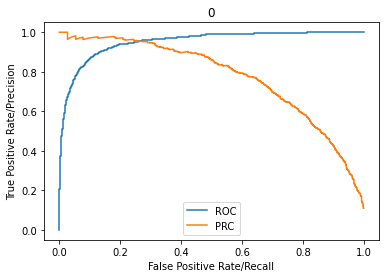

PRC AUC:0.7749430585304471
ROC AUC:0.9511936666666666


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

probs = TrainedModel.predict_proba(X_t)
fpr1, tpr1, thresholds1 = roc_curve(Y_test[:,0], probs[:,0])
prec1, recall1, thresholds1 = precision_recall_curve(Y_test[:,0], probs[:,0])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('0')
plt.show()

print("PRC AUC:" + str(auc(recall1, prec1)))
print("ROC AUC:" + str(auc(fpr1, tpr1)))

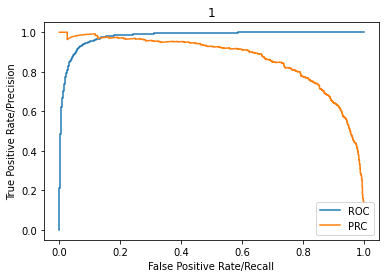

PRC AUC:0.8674534477646637
ROC AUC:0.9789286666666667


In [ ]:
fpr2, tpr2, thresholds2 = roc_curve(Y_test[:,1], probs[:, 1])
prec2, recall2, thresholds2 = precision_recall_curve(Y_test[:,1], probs[:, 1])

plt.plot(fpr2,tpr2,label="ROC")
plt.plot(recall2,prec2,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('1')
plt.show()

print("PRC AUC:" + str(auc(recall2, prec2)))
print("ROC AUC:" + str(auc(fpr2, tpr2)))

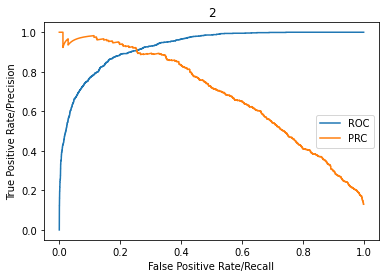

PRC AUC:0.6856787275468913
ROC AUC:0.9270647222222224


In [ ]:
fpr3, tpr3, thresholds3 = roc_curve(Y_test[:,2], probs[:, 2])
prec3, recall3, thresholds3 = precision_recall_curve(Y_test[:,2], probs[:, 2])

plt.plot(fpr3,tpr3,label="ROC")
plt.plot(recall3,prec3,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('2')
plt.show()

print("PRC AUC:" + str(auc(recall3, prec3)))
print("ROC AUC:" + str(auc(fpr3, tpr3)))

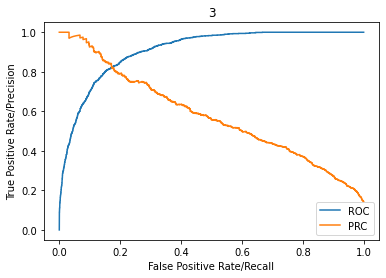

PRC AUC:0.5802635642055272
ROC AUC:0.9078307777777778


In [ ]:
fpr4, tpr4, thresholds4 = roc_curve(Y_test[:,3], probs[:, 3])
prec4, recall4, thresholds4 = precision_recall_curve(Y_test[:,3], probs[:, 3])

plt.plot(fpr4,tpr4,label="ROC")
plt.plot(recall4,prec4,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('3')
plt.show()

print("PRC AUC:" + str(auc(recall4, prec4)))
print("ROC AUC:" + str(auc(fpr4, tpr4)))

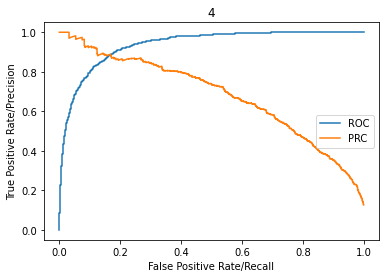

PRC AUC:0.6826089696699127
ROC AUC:0.9361636666666666


In [ ]:
fpr5, tpr5, thresholds5 = roc_curve(Y_test[:,4], probs[:, 4])
prec5, recall5, thresholds5 = precision_recall_curve(Y_test[:,4], probs[:, 4])

plt.plot(fpr5,tpr5,label="ROC")
plt.plot(recall5,prec5,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('4')
plt.show()

print("PRC AUC:" + str(auc(recall5, prec5)))
print("ROC AUC:" + str(auc(fpr5, tpr5)))

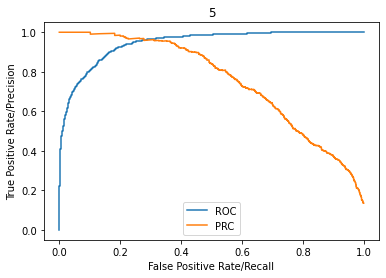

PRC AUC:0.7540911375433158
ROC AUC:0.9441317777777778


In [ ]:
fpr6, tpr6, thresholds6 = roc_curve(Y_test[:,5], probs[:, 5])
prec6, recall6, thresholds6 = precision_recall_curve(Y_test[:,5], probs[:, 5])

plt.plot(fpr6,tpr6,label="ROC")
plt.plot(recall6,prec6,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('5')
plt.show()

print("PRC AUC:" + str(auc(recall6, prec6)))
print("ROC AUC:" + str(auc(fpr6, tpr6)))

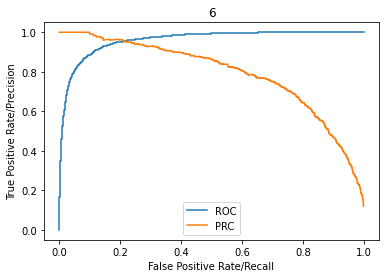

PRC AUC:0.7920630565245869
ROC AUC:0.959916


In [ ]:
fpr7, tpr7, thresholds7 = roc_curve(Y_test[:,6], probs[:, 6])
prec7, recall7, thresholds7 = precision_recall_curve(Y_test[:,6], probs[:, 6])

plt.plot(fpr7,tpr7,label="ROC")
plt.plot(recall7,prec7,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('6')
plt.show()

print("PRC AUC:" + str(auc(recall7, prec7)))
print("ROC AUC:" + str(auc(fpr7, tpr7)))

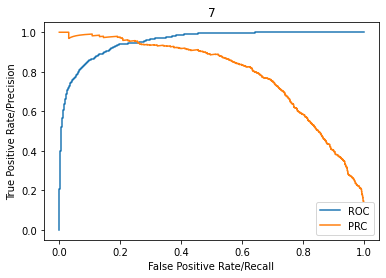

PRC AUC:0.787629481868
ROC AUC:0.9542816666666666


In [ ]:
fpr8, tpr8, thresholds8 = roc_curve(Y_test[:,7], probs[:, 7])
prec8, recall8, thresholds8 = precision_recall_curve(Y_test[:,7], probs[:, 7])

plt.plot(fpr8,tpr8,label="ROC")
plt.plot(recall8,prec8,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('7')
plt.show()

print("PRC AUC:" + str(auc(recall8, prec8)))
print("ROC AUC:" + str(auc(fpr8, tpr8)))

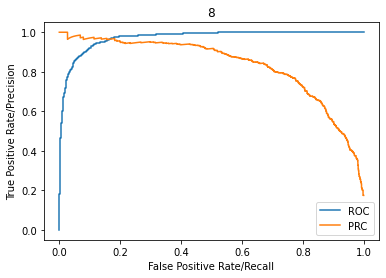

PRC AUC:0.8343419273069856
ROC AUC:0.9720667777777777


In [ ]:
fpr9, tpr9, thresholds9 = roc_curve(Y_test[:,8], probs[:, 8])
prec9, recall9, thresholds9 = precision_recall_curve(Y_test[:,8], probs[:, 8])

plt.plot(fpr9,tpr9,label="ROC")
plt.plot(recall9,prec9,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('8')
plt.show()

print("PRC AUC:" + str(auc(recall9, prec9)))
print("ROC AUC:" + str(auc(fpr9, tpr9)))

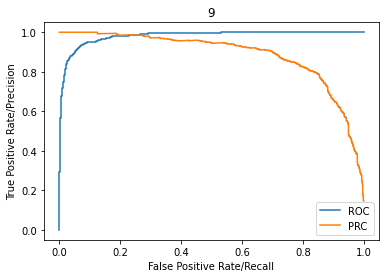

PRC AUC:0.8869316053169056
ROC AUC:0.9801668888888889


In [ ]:
fpr10, tpr10, thresholds10 = roc_curve(Y_test[:,9], probs[:, 9])
prec10, recall10, thresholds10 = precision_recall_curve(Y_test[:,9], probs[:, 9])

plt.plot(fpr10,tpr10,label="ROC")
plt.plot(recall10,prec10,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('9')
plt.show()

print("PRC AUC:" + str(auc(recall10, prec10)))
print("ROC AUC:" + str(auc(fpr10, tpr10)))